## 1. 加载数据并标准化
这里直接使用封装好的数据集 load_breast_cancer 来作为数据集。为了防止量纲对后续模型收敛速度造成影响，遂使用 StandardScaler 来将数据进行标准化处理，将均值变为0，方差变为1。

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
data = load_breast_cancer()
x = data.data  # 提取每个样本的特征数据 shape: (569, 30)
y = data.target  # 提取每个样本对应的标签 shape: (569)

# 标准化，使每一列均值为0，方差为1
scaler = StandardScaler()
x_std = scaler.fit_transform(x)

## 2. 进行 pca 主成分分析，获取前 30 个主成分，并进行主成分可解释性分析
前几个主成分的方差贡献率占比非常大，之后的主成分贡献率大幅下降。在前两主成分散点图中，可以看到：即使只使用前两个主成分，也已经能对样本进行较为有效的解释。

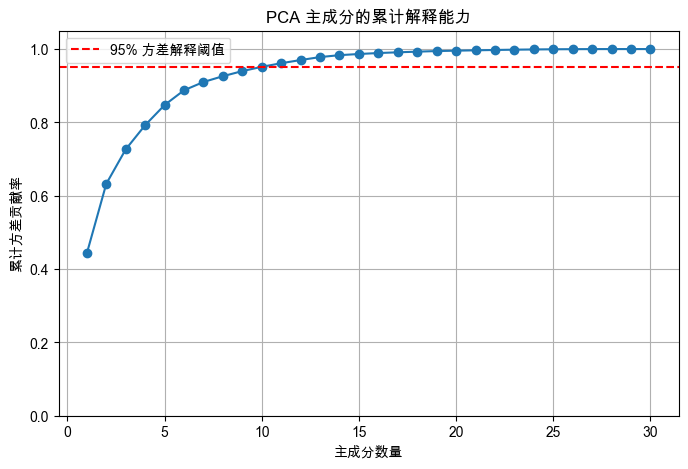

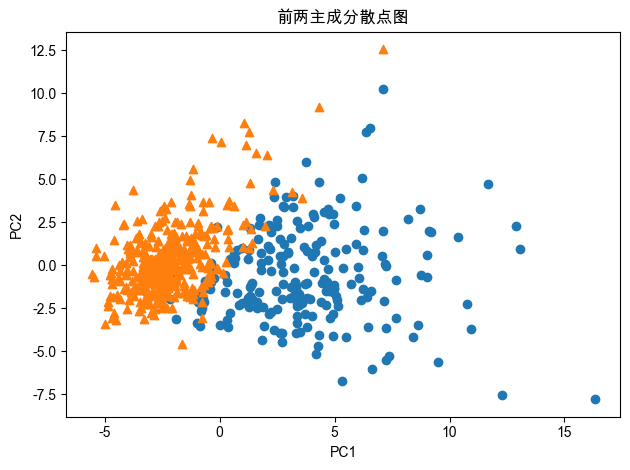

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA

matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False

# 拟合 PCA，获取 30 个主成分
pca = PCA(n_components=30)
x_pca = pca.fit_transform(x_std)

# 主成分可解释性分析
plt.figure(figsize=(8, 5))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, 31), cumulative_variance, marker='o')
plt.xlabel('主成分数量')
plt.ylabel('累计方差贡献率')
plt.title('PCA 主成分的累计解释能力')
plt.grid(True)
plt.ylim(0, 1.05)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% 方差解释阈值')
plt.legend()
plt.show()

# 前两主成分散点图（区分两类）
plt.figure()
plt.scatter(x_pca[data.target == 0, 0], x_pca[data.target == 0, 1], marker='o')
plt.scatter(x_pca[data.target == 1, 0], x_pca[data.target == 1, 1], marker='^')
plt.title('前两主成分散点图')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

## 3. 调整使用主成分的数量，进行预测
可以看到输出了警告信息，说明未进行标准化的原始数据收敛速度非常慢，到达 1000 轮时仍未收敛。

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 对比使用不同数量的主成分的降维效果
accuracies = []
dimensions = list(range(1, 31))

for d in dimensions:
    # 使用 pca 的前 d 个主成分投影
    x_pca_d = x_std @ pca.components_[:d].T

    # 使用降维之后的数据训练逻辑回归模型并评估预测能力
    x_train, x_test, y_train, y_test = train_test_split(x_pca_d, y, test_size=0.3, random_state=0)
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# 使用原始数据（标准化但未降维）训练逻辑回归作对比
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x_std, y, test_size=0.3, random_state=0)
model_full = LogisticRegression(max_iter=1000)
model_full.fit(x_train_full, y_train_full)
accuracy_full1 = accuracy_score(y_test_full, model_full.predict(x_test_full))

# 使用原始数据（未标准化也未降维）训练逻辑回归作对比
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x, y, test_size=0.3, random_state=0)
model_full = LogisticRegression(max_iter=1000)
model_full.fit(x_train_full, y_train_full)
accuracy_full2 = accuracy_score(y_test_full, model_full.predict(x_test_full))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 4. 可视化预测结果

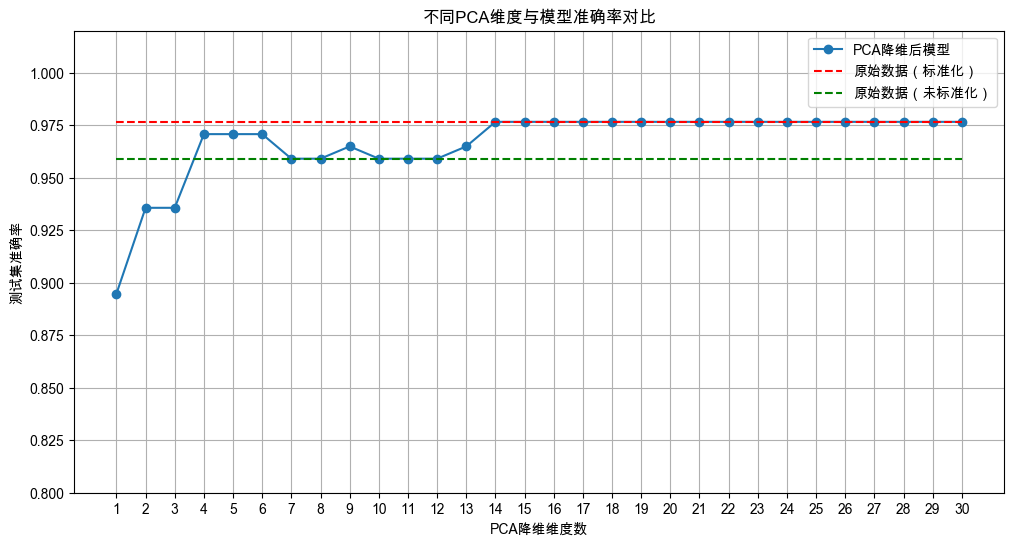

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(dimensions, accuracies, marker='o', label='PCA降维后模型')
plt.hlines(accuracy_full1, xmin=1, xmax=30, colors='r', linestyles='--', label='原始数据（标准化）')
plt.hlines(accuracy_full2, xmin=1, xmax=30, colors='g', linestyles='--', label='原始数据（未标准化）')
plt.title('不同PCA维度与模型准确率对比')
plt.xlabel('PCA降维维度数')
plt.ylabel('测试集准确率')
plt.xticks(dimensions)
plt.ylim(0.8, 1.02)
plt.grid(True)
plt.legend()
plt.show()